In [1]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore') # 불필요한 경고 출력 방지

## 앙상블 모델


### 유방암 진단 데이터 로드 & 데이터 세트 분리

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 데이터 로드
cancer = load_breast_cancer()

# 학습/테스트 데이터 분할(test_size: 30%, stratify 옵션 사용)
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                 test_size=0.2, random_state=156,
                                                 stratify=cancer.target)

# target 데이터의 분포가 불균형하여 stratify 적용(특별히 이번에만 적용한 다른 이유가 있는 것은 아님)

### 랜덤 포레스트 모델 적용

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 모델 객체 생성(n_jobs 옵션 사용)
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# 모델 학습
rf_clf.fit(x_train, y_train)

# 예측값 생성
pred = rf_clf.predict(x_test)

# 예측 정확도 출력
print(f'Random Forest Accuracy: {accuracy_score(y_test, pred):.4f}')

Random Forest Accuracy: 0.9649


### GridSearchCV 하이퍼 파라미터 조정

In [4]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 dictionary 형태로 저장
params = {'n_estimators':[500],
          'max_depth':[3, 4, 5, 6, 8],
          'min_samples_split':[2, 3, 4, 8, 10]}

# GridSearchCV 수행(cv=2, n_job=-1) -> GridSearchCV에도 n_jobs 옵션 존재
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)

# 모델 학습
grid_cv.fit(x_train, y_train)

# 최적의 파라미터와 최고의 정확도 출력
print('Optimal Hyper Parameter:', grid_cv.best_params_)
print(f'Max Accuracy: {grid_cv.best_score_:.4f}')

Optimal Hyper Parameter: {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 500}
Max Accuracy: 0.9450


In [5]:
from sklearn.metrics import accuracy_score

# 예측값 생성
grid_pred = grid_cv.predict(x_test) 

# 예측 정확도 출력
accur = accuracy_score(y_test, grid_pred)
print(f'Test Data Accuracy: {accur:.4f}')

Test Data Accuracy: 0.9737


In [6]:
# 최적의 파라미터를 사용하여 RandomForestClassifier 객체 생성
rf_clf_grid = RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_split=2,
                                     n_jobs = -1, random_state = 0)

# 모델 학습, 예측 수행, 성능 지표 출력
rf_clf_grid.fit(x_train, y_train)
pred = rf_clf_grid.predict(x_test)

accur = accuracy_score(y_test, pred)
print(f'Accuracy: {accur:.4f}')

# GridSearchCV는 특성 중요도를 반환하지 않으므로,
# 특성 중요도를 살펴보기 위해 최적의 파라미터로 Random Forest 모델로 학습/예측 한 번 더 수행

Accuracy: 0.9737


### Feature Importance(특성 중요도)

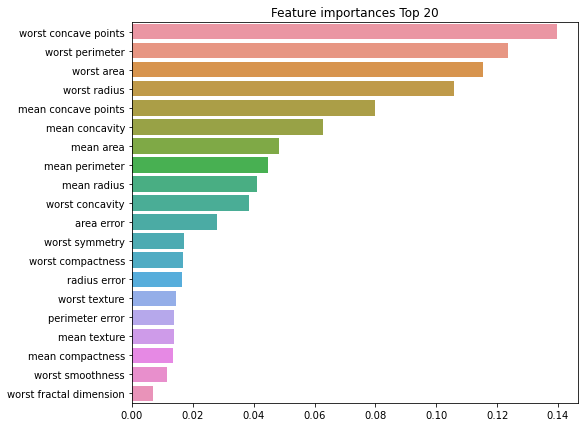

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 특성 중요도를 ftr_importances_values 변수에 저장
ftr_importances_values = rf_clf_grid.feature_importances_

# numpy 배열 형식의 feature_importances_를 보기 편한 Series 형태로 변환
# 넘파이 어레이 형식이므로 보기 편하게 시리즈 안에 넣어줌
ftr_importances = pd.Series(ftr_importances_values, index=cancer.feature_names)

# 중요도 상위 20개의 feature를 ftr_top20 변수에 저장
# Series는 컬럼이 하나이므로 sort 기준이 되는 컬럼을 적어줄 필요 없음(by=)
ftr_top20 = ftr_importances.sort_values(ascending=False).head(20) # [:20]

# ftr_top20 막대그래프 출력
plt.figure(figsize=(8, 7))
plt.title('Feature importances Top 20')
sns.barplot(x= ftr_top20, y=ftr_top20.index)

plt.show()

In [9]:
from sklearn.metrics import confusion_matrix,f1_score

# confusion_matrix 출력
cm = confusion_matrix(y_test, pred)
cm

array([[41,  1],
       [ 2, 70]], dtype=int64)

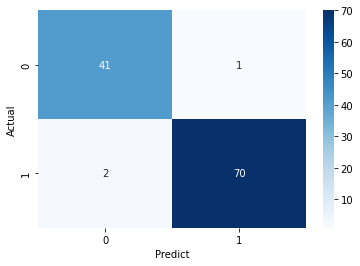

In [10]:
# 히트맵으로 정오 행렬 출력(malignant: 0, benign: 1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 성능 지표(accuracy, precision, recall, f1 score) 출력

acccuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f'Accuracy(Test): {acccuracy:.4f}')
print(f'Precision(Test): {precision:.4f}')
print(f'Recall(Test): {recall:.4f}')
print(f'F1 Score(Test): {f1:.4f}')

Accuracy(Test): 0.9737
Precision(Test): 0.9859
Recall(Test): 0.9722
F1 Score(Test): 0.9790


#### 분류모델 성능비교 함수

In [12]:
# 학습과 예측에 사용된 모델의 성능을 그래프로 시각화하여 확인하기 위한 함수 생성

import matplotlib.pyplot as plt
import seaborn as sns


# 무작위로 그래프 색상을 선택하기 위한 색상 list
colors = ['b','g','r', 'c', 'm', 'y', 'k', 
          'lightcoral', 'mistyrose', 'tomato', 'darkred', 'sienna',
          'forestgreen', 'royalblue', 'orange', 'lemonchiffon','skyblue',
          'chocolate', 'greenyellow','lime','aqua','lightpink','lightgreen',
          'gold', 'seagreen', 'deepskyblue', 'steelblue', 'slategray']


# 1) add_accuracy()
# 학습/예측을 실행한 모델명을 key로, 예측값과 실데이터의 예측 정확도를 value로 predictions에 저장
# predictions에 모델명이 없으면 추가, 이미 존재하면 수정

predictions = {} # 알고리즘의 이름과 예측 정확도를 저장할 dictionary

def add_accuracy(model_name, acc):
    
    global predictions
    
    predictions[model_name] = acc # predictions에 모델 이름과 해당 모델의 예측 정확도를 저장


# 3) accuracy_graph()
# predictions에 저장된 모델명과 예측 정확도를 그래프(barh)로 나타내는 함수

def accuracy_graph():
    
    global predictions
    global colors

    eval_value = sorted(predictions.items(), key=lambda x: x[1], reverse=False)
    
    df = pd.DataFrame(eval_value, columns=['model', 'accuracy'])
    print(df)
    
    fig, axes = plt.subplots(figsize=(7, len(df)))
    axes.set_yticks(np.arange(len(df)))
    axes.set_yticklabels(df['model'], fontsize=15)
    bars = axes.barh(np.arange(len(df)), df['accuracy'])
    
    for i, v in enumerate(df['accuracy']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        # axes.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        axes.text(1, i, str(round(v, 4)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('Accuracy ', fontsize=15)
    plt.xlim(0, 2)

## 분류 모델 성능 비교

###  Logistic Regression

                model  accuracy
0  LogisticRegression  0.947368


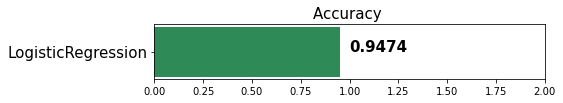

In [14]:
from sklearn.linear_model import LogisticRegression

# 객체 생성, 학습, 예측
log_reg =  LogisticRegression()
log_reg.fit(x_train, y_train)
pred = log_reg.predict(x_test)

# 예측 정확도 변수 생성
lr_acc = accuracy_score(y_test, pred)

# 예측 정확도 시각화
add_accuracy('LogisticRegression', lr_acc)
accuracy_graph()

### Random Forest

                model  accuracy
0  LogisticRegression  0.947368
1       Random Forest  0.964912


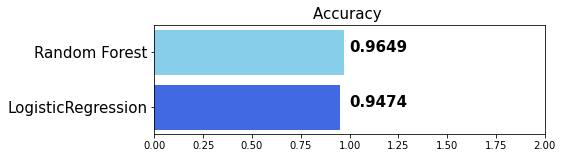

In [15]:
from sklearn.ensemble import RandomForestClassifier

# 객체 생성, 학습, 예측
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_clf.fit(x_train, y_train)
rf_pred = rf_clf.predict(x_test)

# 예측 정확도 시각화
rf_acc = accuracy_score(y_test, rf_pred)
add_accuracy('Random Forest', rf_acc)
accuracy_graph()

###  Random Forest - tuning

                  model  accuracy
0    LogisticRegression  0.947368
1         Random Forest  0.964912
2  Random Forest Tuning  0.973684


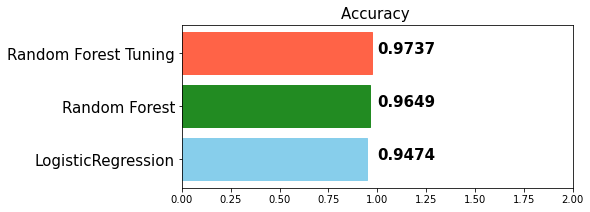

In [16]:
rf_clf_tuning = RandomForestClassifier(n_estimators=500,
                                 max_depth=8,
                                 min_samples_split=2,
                                 n_jobs=-1, random_state=0)

# 모델 학습, 예측 수행
rf_clf_tuning.fit(x_train, y_train)
rf_tunning_pred = rf_clf_tuning.predict(x_test)

# 예측 정확도 시각화
rf_tuning_acc = accuracy_score(y_test, rf_tunning_pred)
add_accuracy('Random Forest Tuning',rf_tuning_acc)
accuracy_graph()

# 최적의 하이퍼 파라미터를 넣어서 튜닝한 모델의 성능이 가장 우수함

## 부스팅 계열의 알고리즘
### XGBoost

[공식문서](https://xgboost.readthedocs.io/en/latest/)

- scikit-learn 패키지에 속한 모델이 아니므로 xgboost 설치 필요
- !pip install xgboost: jupyter notebook 셀에서 설치 시 ! 삽입

                  model  accuracy
0    LogisticRegression  0.947368
1         Random Forest  0.964912
2  Random Forest Tuning  0.973684
3               XGBoost  0.982456


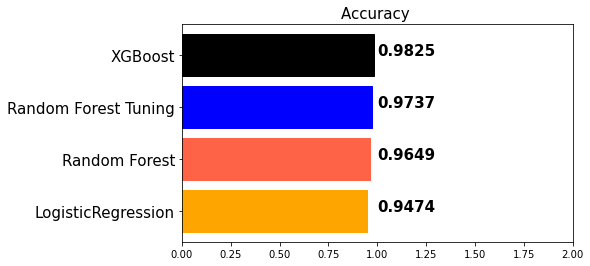

In [21]:
from xgboost import XGBClassifier # 회귀 모델의 경우 XGBRegressor 사용

# 모델 객체 생성, 모델 학습, 예측 수행
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

# 예측 정확도 시각화
xgb_acc = accuracy_score(y_test, xgb_pred)
add_accuracy('XGBoost',xgb_acc)
accuracy_graph()

# 예측에 실패한 값을 집중적으로 재학습하는 부스팅 계열 알고리즘의 성능이 가장 우수함

### XGBoost - tuning

**주요 Hyperparameter**
- n_jobs : CPU 사용 개수
- learning_rate : 학습률
 - 너무 큰 학습률은 성능을 떨어뜨리고, 너무 작은 학습률은 학습이 느리므로 적절한 값을 찾아야 함(default=0.1)
 - 경사 하강법: 같은 간격(Learning-Rate)으로 이동하면서 최소 오차를 찾아가는데, 간격이 너무 크면 최소 오차를 지나칠 수 있음
- n_estimators : 부스팅 스테이지 수(랜덤 포레스트 트리의 개수 설정과 비슷한 개념, default=100)
- max_depth : 의사결정나무의 최대 깊이(과대적합 방지용, default=3)
- subsample : 샘플 사용 비율(과대적합 방지용, default=1)
- max_features : 최대로 사용할 feature의 비율(과대적합 방지용, default=1)

                  model  accuracy
0    LogisticRegression  0.947368
1         Random Forest  0.964912
2  Random Forest Tuning  0.973684
3               XGBoost  0.982456
4        XGBoost Tuning  0.982456


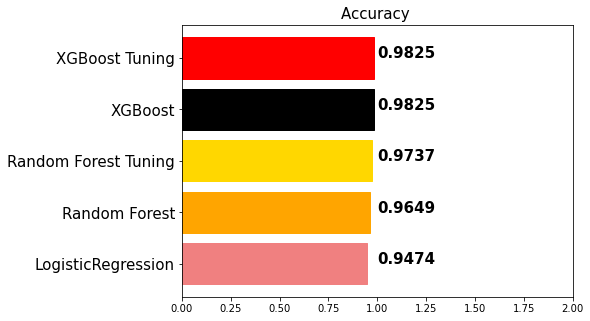

In [22]:
xgb_t = XGBClassifier(random_state=42, learning_rate=0.01, 
                      n_estimators=1000, subsample=0.8,  max_depth=7)

# 모델 학습, 예측 수행
xgb_t.fit(x_train, y_train)
xgb_t_pred = xgb_t.predict(x_test)

# 예측 정확도 시각화
xgb_t_acc = accuracy_score(y_test, xgb_t_pred)
add_accuracy('XGBoost Tuning', xgb_t_acc)
accuracy_graph()